Dans un premier temps, le modèle LeNet sera testé sur les données brutes sans masque appliqué, pour vérifier que tout fonctionne correctement.

In [16]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [17]:
lung_seg_path = os.path.join("..", "data", "processed","Lung Segmentation Data")

In [18]:
def load_images(folder_path, num_images, final_folder):
    '''Cette fonction permet de charger les images qui seront utilisées pour le modèle LeNet.
    folder_path est le chemin vers le dossier contenant l'ensemble des images (qui contient normalement 3 sous-dossiers)
    num_images est le nombre d'images que l'on souhaite importer par sous dossier
    final_folder est le dossier final dans lequel les images sont contenues : "images" pour les données brutes, "lung_masks" pour les masques...'''

    images = []
    labels = []

    for subfolder in os.listdir(folder_path): # Je parcours les sous-dossiers (Covid, Non-covid, Normal)
        subfolder_path = os.path.join(folder_path, subfolder, final_folder) # Les images se situent encore dans un sous dossier

        for image in tqdm(os.listdir(subfolder_path)[:num_images]):
            image_path = os.path.join(subfolder_path, image)
            img = cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(subfolder)
    
    return images, labels


In [19]:
image, label = load_images(lung_seg_path, 1000, "images") # Images brutes

  8%|▊         | 77/1000 [00:00<00:01, 764.41it/s]

100%|██████████| 1000/1000 [00:01<00:00, 805.36it/s]


In [20]:
image_norm, label_norm = load_images(lung_seg_path, 1000, "MinMaxNormalized images")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 241.66it/s]


In [21]:
# Transformation des labels pour ne plus avoir des strings
label_encoder = LabelEncoder()
targets_encoded = label_encoder.fit_transform(label) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded.shape

(3000,)

In [22]:
# Transformation des labels pour ne plus avoir des strings (Images normalisées)
label_encoder_norm = LabelEncoder()
targets_encoded_norm = label_encoder_norm.fit_transform(label_norm) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded_norm.shape

(3000,)

In [23]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur)
images_encoded = np.stack(image)
images_encoded = images_encoded.reshape((-1, 256, 256, 1))
images_encoded.shape

(3000, 256, 256, 1)

In [24]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur) (Images normalisées)
images_encoded_norm = np.stack(image_norm)
images_encoded_norm = images_encoded_norm.reshape((-1, 256, 256, 1))
images_encoded_norm.shape

(3000, 256, 256, 1)

In [25]:
# Séparation des données en ensembles de test et train
X_train, X_test, y_train, y_test = train_test_split(images_encoded, targets_encoded, test_size=0.2, random_state=42)

In [26]:
# Séparation des données en ensembles de test et train (Images normalisées)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(images_encoded_norm, targets_encoded_norm, test_size=0.2, random_state=42)

In [27]:
from keras.utils import to_categorical

In [28]:
# Labels en vecteurs catégoriels binaires
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Données de X comprises entre 0 et 1
X_train = X_train / 255
X_test = X_test / 255

In [29]:
# Images normalisées
# Labels en vecteurs catégoriels binaires
y_norm_train = to_categorical(y_norm_train)
y_norm_test = to_categorical(y_norm_test)

# Données de X comprises entre 0 et 1
X_norm_train = X_norm_train / 255
X_norm_test = X_norm_test / 255

Création du modèle LeNet

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

In [31]:
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

tf.config.list_physical_devices('GPU') # Si la liste est vide, le GPU n'est pas détecté

[]

In [32]:
# Architecture du modèle
inputs=Input(shape = (256, 256,1), name = "Input")


conv_1 = Conv2D(filters = 30,                    # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 3,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)


x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

d:\Nico\Code\MAR24_BDS_Radios_Pulmonaire\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet = lenet.fit(X_train, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.4171 - loss: 1.3653 - val_accuracy: 0.5396 - val_loss: 0.9406
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6486 - loss: 0.8464 - val_accuracy: 0.7625 - val_loss: 0.5632
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7690 - loss: 0.5908 - val_accuracy: 0.7667 - val_loss: 0.5599
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7980 - loss: 0.5345 - val_accuracy: 0.8167 - val_loss: 0.4654
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8491 - loss: 0.4458 - val_accuracy: 0.8167 - val_loss: 0.4803
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8701 - loss: 0.4077 - val_accuracy: 0.8604 - val_loss: 0.3977
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8772 - loss: 0.3538 - val_accuracy: 0.8208 - val_loss: 0.4816
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8728 - loss: 0.3675 - val_accuracy: 0.8500 - val_loss:

In [34]:
all_val_accuracy=[]
train_acc_lenet = training_history_lenet.history['accuracy']
all_val_accuracy.append(training_history_lenet.history['val_accuracy'])


# Results
test_pred_lenet = lenet.predict(X_test)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_lenet_class))
pd.crosstab(y_test_class, test_pred_lenet_class)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       217
           1       0.90      0.90      0.90       197
           2       0.81      0.82      0.82       186

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.85      0.86       600



col_0,0,1,2
row_0,,,
0,182,9,26
1,10,178,9
2,23,10,153


In [35]:
lenet_norm = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet_norm.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet_norm = lenet_norm.fit(X_norm_train, y_norm_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6780 - loss: 1.6383 - val_accuracy: 0.7396 - val_loss: 0.6670
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8009 - loss: 0.5018 - val_accuracy: 0.8000 - val_loss: 0.5563
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8841 - loss: 0.3954 - val_accuracy: 0.8542 - val_loss: 0.4525
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8968 - loss: 0.3372 - val_accuracy: 0.8417 - val_loss: 0.4319
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9156 - loss: 0.2840 - val_accuracy: 0.8521 - val_loss: 0.4299
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9175 - loss: 0.2693 - val_accuracy: 0.8583 - val_loss: 0.4322
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9200 - loss: 0.2480 - val_accuracy: 0.8604 - val_loss: 0.4024
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9287 - loss: 0.2182 - val_accuracy: 0.8625 - val_loss:

In [36]:
all_val_accuracy_norm=[]
train_acc_lenet_norm = training_history_lenet_norm.history['accuracy']
all_val_accuracy_norm.append(training_history_lenet_norm.history['val_accuracy'])


# Results
test_pred_lenet_norm = lenet_norm.predict(X_norm_test)
test_pred_lenet_class_norm = test_pred_lenet_norm.argmax(axis = 1)
y_test_class_norm = y_norm_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class_norm, test_pred_lenet_class_norm))
pd.crosstab(y_test_class_norm, test_pred_lenet_class_norm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       217
           1       0.89      0.89      0.89       197
           2       0.83      0.85      0.84       186

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



col_0,0,1,2
row_0,,,
0,184,11,22
1,12,175,10
2,18,10,158


Test modèle LeNet avec les masques non-aggrandis

In [37]:
image_mask, label_mask = load_images(lung_seg_path, 1000, "masks_applicated")

100%|██████████| 1000/1000 [00:01<00:00, 542.37it/s]


In [38]:
# Transformation des labels pour ne plus avoir des strings (Images masquées)
label_encoder_mask = LabelEncoder()
targets_encoded_mask = label_encoder_mask.fit_transform(label_mask) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded_mask.shape

(3000,)

In [39]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur) (Images masquées)
images_encoded_mask = np.stack(image_mask)
images_encoded_mask = images_encoded_mask.reshape((-1, 256, 256, 1))
images_encoded_mask.shape

(3000, 256, 256, 1)

In [40]:
# Séparation des données en ensembles de test et train (Images masquées)
X_mask_train, X_mask_test, y_mask_train, y_mask_test = train_test_split(images_encoded_mask, targets_encoded_mask, test_size=0.2, random_state=42)

In [41]:
# Images masquées
# Labels en vecteurs catégoriels binaires
y_mask_train = to_categorical(y_mask_train)
y_mask_test = to_categorical(y_mask_test)

# Données de X comprises entre 0 et 1
X_mask_train = X_mask_train / 255
X_mask_test = X_mask_test / 255

In [42]:
lenet_mask = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet_mask.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet_mask = lenet_mask.fit(X_mask_train, y_mask_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3955 - loss: 2.8453 - val_accuracy: 0.5375 - val_loss: 1.0381
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5884 - loss: 0.9106 - val_accuracy: 0.6438 - val_loss: 0.7731
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7215 - loss: 0.6882 - val_accuracy: 0.7208 - val_loss: 0.6453
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7586 - loss: 0.5773 - val_accuracy: 0.7354 - val_loss: 0.5972
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7878 - loss: 0.5358 - val_accuracy: 0.7479 - val_loss: 0.6037
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8257 - loss: 0.4593 - val_accuracy: 0.7396 - val_loss: 0.5856
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8447 - loss: 0.4252 - val_accuracy: 0.7625 - val_loss: 0.5734
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8472 - loss: 0.3915 - val_accuracy: 0.7542 - val_loss:

In [43]:
all_val_accuracy_mask=[]
train_acc_lenet_mask = training_history_lenet_mask.history['accuracy']
all_val_accuracy_mask.append(training_history_lenet_mask.history['val_accuracy'])

# Results
test_pred_lenet_mask = lenet_mask.predict(X_mask_test)
test_pred_lenet_class_mask = test_pred_lenet_mask.argmax(axis = 1)
y_test_class_mask = y_mask_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class_mask, test_pred_lenet_class_mask))
pd.crosstab(y_test_class_mask, test_pred_lenet_class_mask)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       217
           1       0.83      0.88      0.86       197
           2       0.63      0.74      0.68       186

    accuracy                           0.72       600
   macro avg       0.72      0.73      0.72       600
weighted avg       0.72      0.72      0.72       600



col_0,0,1,2
row_0,,,
0,121,25,71
1,14,174,9
2,39,10,137


Test LeNet avec masques dilatés une fois

In [44]:
image_mask_dil1, label_mask_dil1 = load_images(lung_seg_path, 1000, "masks_dilated1_applicated")

100%|██████████| 1000/1000 [00:01<00:00, 669.13it/s]


In [45]:
# Transformation des labels pour ne plus avoir des strings (Images masquées dilatées 1 fois)
label_encoder_mask_dil1 = LabelEncoder()
targets_encoded_mask_dil1 = label_encoder_mask_dil1.fit_transform(label_mask_dil1) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded_mask_dil1.shape

(3000,)

In [46]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur) (Images masquées dilatées 1 fois)
images_encoded_mask_dil1 = np.stack(image_mask_dil1)
images_encoded_mask_dil1 = images_encoded_mask_dil1.reshape((-1, 256, 256, 1))
images_encoded_mask_dil1.shape

(3000, 256, 256, 1)

In [47]:
# Séparation des données en ensembles de test et train (Images masquées dilatées une fois)
X_mask_dil1_train, X_mask_dil1_test, y_mask_dil1_train, y_mask_dil1_test = train_test_split(images_encoded_mask_dil1, targets_encoded_mask_dil1, test_size=0.2, random_state=42)

In [48]:
# Images masquées dilatées 1 fois
# Labels en vecteurs catégoriels binaires
y_mask_dil1_train = to_categorical(y_mask_dil1_train)
y_mask_dil1_test = to_categorical(y_mask_dil1_test)

# Données de X comprises entre 0 et 1
X_mask_dil1_train = X_mask_dil1_train / 255
X_mask_dil1_test = X_mask_dil1_test / 255

In [49]:
lenet_mask_dil1 = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet_mask_dil1.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet_mask_dil1 = lenet_mask_dil1.fit(X_mask_dil1_train, y_mask_dil1_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8215 - loss: 0.5309 - val_accuracy: 0.6896 - val_loss: 0.8499
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8653 - loss: 0.3331 - val_accuracy: 0.7333 - val_loss: 0.7808
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9223 - loss: 0.2222 - val_accuracy: 0.7458 - val_loss: 0.8575
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9393 - loss: 0.1689 - val_accuracy: 0.7458 - val_loss: 0.9410
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9408 - loss: 0.1525 - val_accuracy: 0.7563 - val_loss: 0.9353
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9621 - loss: 0.1073 - val_accuracy: 0.7437 - val_loss: 1.0154
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9761 - loss: 0.0925 - val_accuracy: 0.7521 - val_loss: 1.0395
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9802 - loss: 0.0715 - val_accuracy: 0.7521 - val_loss:

In [50]:
all_val_accuracy_mask_dil1=[]
train_acc_lenet_mask_dil1 = training_history_lenet_mask_dil1.history['accuracy']
all_val_accuracy_mask_dil1.append(training_history_lenet_mask_dil1.history['val_accuracy'])

# Results
test_pred_lenet_mask_dil1 = lenet_mask_dil1.predict(X_mask_dil1_test)
test_pred_lenet_class_mask_dil1 = test_pred_lenet_mask_dil1.argmax(axis = 1)
y_test_class_mask_dil1 = y_mask_dil1_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class_mask_dil1, test_pred_lenet_class_mask_dil1))
pd.crosstab(y_test_class_mask_dil1, test_pred_lenet_class_mask_dil1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       217
           1       0.85      0.87      0.86       197
           2       0.62      0.73      0.67       186

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.71       600



col_0,0,1,2
row_0,,,
0,122,20,75
1,15,172,10
2,39,11,136


Test LeNet avec masques dilatés deux fois

In [51]:
image_mask_dil2, label_mask_dil2 = load_images(lung_seg_path, 1000, "masks_dilated2_applicated")

100%|██████████| 1000/1000 [00:01<00:00, 578.66it/s]


In [52]:
# Transformation des labels pour ne plus avoir des strings (Images masquées dilatées 2 fois)
label_encoder_mask_dil2 = LabelEncoder()
targets_encoded_mask_dil2 = label_encoder_mask_dil2.fit_transform(label_mask_dil2) #COVID-19 =0, Non_COVID =1, Normal =2
targets_encoded_mask_dil2.shape

(3000,)

In [53]:
# Transformation de la liste d'images en tableau à 4 dimensions (nb_images, largeur, hauteur, profondeur) (Images masquées dilatées 2 fois)
images_encoded_mask_dil2 = np.stack(image_mask_dil2)
images_encoded_mask_dil2 = images_encoded_mask_dil2.reshape((-1, 256, 256, 1))
images_encoded_mask_dil2.shape

(3000, 256, 256, 1)

In [54]:
# Séparation des données en ensembles de test et train (Images masquées dilatées 2 fois)
X_mask_dil2_train, X_mask_dil2_test, y_mask_dil2_train, y_mask_dil2_test = train_test_split(images_encoded_mask_dil2, targets_encoded_mask_dil2, test_size=0.2, random_state=42)

In [55]:
# Images masquées dilatées 1 fois
# Labels en vecteurs catégoriels binaires
y_mask_dil2_train = to_categorical(y_mask_dil2_train)
y_mask_dil2_test = to_categorical(y_mask_dil2_test)

# Données de X comprises entre 0 et 1
X_mask_dil2_train = X_mask_dil2_train / 255
X_mask_dil2_test = X_mask_dil2_test / 255

In [56]:
lenet_mask_dil2 = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet_mask_dil2.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

training_history_lenet_mask_dil2 = lenet_mask_dil2.fit(X_mask_dil2_train, y_mask_dil2_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = 16,               # nombre d'epochs
                                   batch_size = 200)          # taille des batchs

Epoch 1/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8661 - loss: 0.5402 - val_accuracy: 0.6979 - val_loss: 1.2403
Epoch 2/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8981 - loss: 0.2563 - val_accuracy: 0.7312 - val_loss: 1.0803
Epoch 3/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9517 - loss: 0.1336 - val_accuracy: 0.7437 - val_loss: 1.1100
Epoch 4/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9784 - loss: 0.0779 - val_accuracy: 0.7292 - val_loss: 1.2389
Epoch 5/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9847 - loss: 0.0611 - val_accuracy: 0.7396 - val_loss: 1.3080
Epoch 6/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9930 - loss: 0.0329 - val_accuracy: 0.7333 - val_loss: 1.3617
Epoch 7/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9959 - loss: 0.0239 - val_accuracy: 0.7479 - val_loss: 1.4529
Epoch 8/16
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9980 - loss: 0.0194 - val_accuracy: 0.7437 - val_loss:

In [57]:
all_val_accuracy_mask_dil2=[]
train_acc_lenet_mask_dil2 = training_history_lenet_mask_dil2.history['accuracy']
all_val_accuracy_mask_dil2.append(training_history_lenet_mask_dil2.history['val_accuracy'])

# Results
test_pred_lenet_mask_dil2 = lenet_mask_dil2.predict(X_mask_dil2_test)
test_pred_lenet_class_mask_dil2 = test_pred_lenet_mask_dil2.argmax(axis = 1)
y_test_class_mask_dil2 = y_mask_dil2_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class_mask_dil2, test_pred_lenet_class_mask_dil2))
pd.crosstab(y_test_class_mask_dil2, test_pred_lenet_class_mask_dil2)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
              precision    recall  f1-score   support

           0       0.70      0.63      0.66       217
           1       0.85      0.88      0.86       197
           2       0.66      0.72      0.69       186

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600



col_0,0,1,2
row_0,,,
0,136,20,61
1,16,173,8
2,42,10,134


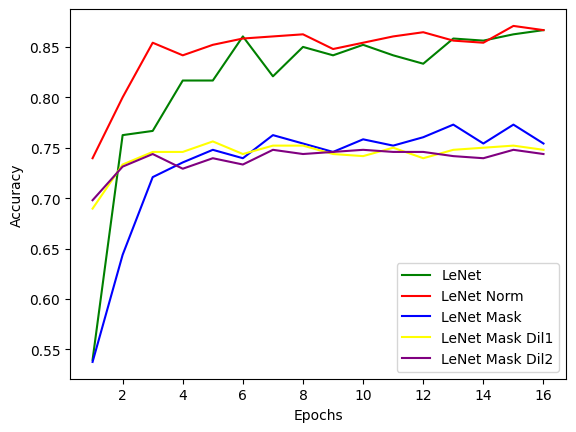

In [58]:
# Graphes combinés de l'ensemble des modèles
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy[0], 
         label = 'LeNet',
         color = 'green')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy_norm[0], 
         label = 'LeNet Norm',
         color = 'red')        
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy_mask[0], 
         label = 'LeNet Mask',
         color = 'blue')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy_mask_dil1[0], 
         label = 'LeNet Mask Dil1',
         color = 'yellow')
plt.plot(np.arange(1 , 17, 1),
         all_val_accuracy_mask_dil2[0], 
         label = 'LeNet Mask Dil2',
         color = 'purple')
plt.legend()

cdzefc